In [140]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [141]:
#import sys
#!{sys.executable} -m pip install -r requirements.txt

In [142]:
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import statsmodels
from statsmodels.tsa.stattools import coint
from datetime import datetime
from datetime import timedelta

# just set the seed for the random number generator
#np.random.seed(107)

In [143]:
# valid intervals - 1m, 3m, 5m, 15m, 30m, 1h, 2h, 4h, 6h, 8h, 12h, 1d, 3d, 1w, 1M
interval = '1m'
pair = 'BTCUSDT'
#pairs = ['BTCUSDT', 'ETHUSDT','ADAUSDT','CHZUSDT','ENJUSDT','LINKUSDT','FILUSDT','XRPUSDT']
#pairs = ['ETHBTC','ADABTC','CHZBTC','ENJBTC','LINKBTC','FILBTC','XRPBTC']

In [144]:
from trade_utils import initialize_ohlc_df

try:
    df = pd.read_csv('data/' + pair + '-' + interval + '-binance-all.csv')
    df['OpenTime'] = pd.to_datetime(df['OpenTime'])
    df.set_index('OpenTime', inplace=True)
except FileNotFoundError:
    df = initialize_ohlc_df()


In [145]:
df.shape

(2040140, 5)

In [146]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2040140 entries, 2017-08-17 04:00:00 to 2021-07-20 10:56:00
Data columns (total 5 columns):
 #   Column      Dtype  
---  ------      -----  
 0   OpenPrice   float64
 1   HighPrice   float64
 2   LowPrice    float64
 3   ClosePrice  float64
 4   Volume      float64
dtypes: float64(5)
memory usage: 93.4 MB


In [147]:
df.head()

,OpenPrice,HighPrice,LowPrice,ClosePrice,Volume
OpenTime,,,,,
2017-08-17 04:00:00,4261.48,4261.48,4261.48,4261.48,1.775183
2017-08-17 04:01:00,4261.48,4261.48,4261.48,4261.48,0.000000
2017-08-17 04:02:00,4280.56,4280.56,4280.56,4280.56,0.261074
2017-08-17 04:03:00,4261.48,4261.48,4261.48,4261.48,0.012008
2017-08-17 04:04:00,4261.48,4261.48,4261.48,4261.48,0.140796


In [148]:
df.tail()

,OpenPrice,HighPrice,LowPrice,ClosePrice,Volume
OpenTime,,,,,
2021-07-20 10:52:00,29635.11,29650.00,29633.52,29633.52,21.700073
2021-07-20 10:53:00,29636.98,29650.00,29620.00,29626.17,21.004906
2021-07-20 10:54:00,29626.18,29663.45,29620.32,29647.14,31.499408
2021-07-20 10:55:00,29647.13,29679.73,29647.13,29674.25,47.474042
2021-07-20 10:56:00,29674.24,29677.20,29660.79,29669.03,27.530645


In [149]:
from binance_utils import update_historical_data

df = update_historical_data(df, pair, interval)

In [150]:
# save all data
filename = 'data/' + pair + '-' + interval + '-binance-all.csv'
df.to_csv(filename)

# reduce data from 2020 until now
df = df['2020-1-1':]
filename = 'data/' + pair + '-' + interval + '-binance.csv'
df.to_csv(filename)


In [151]:
summaries = {'OpenPrice': 'first', 'HighPrice': 'max', 'LowPrice': 'min', 'ClosePrice': 'last', 'Volume': 'sum'}

df_1m = df.copy()

df_15m = df.resample('15min').agg(summaries)
df_15m.dropna(inplace=True)

df_1h = df.resample('1H').agg(summaries)
df_1h.dropna(inplace=True)

df_4h = df.resample('4H').agg(summaries)
df_4h.dropna(inplace=True)

df_1d = df.resample('1D').agg(summaries)
df_1d.dropna(inplace=True)

In [152]:
# select data to generate indicators
data = df_1h.copy()
#data = df_1d.copy()

In [153]:
data.sample(10)

,OpenPrice,HighPrice,LowPrice,ClosePrice,Volume
OpenTime,,,,,
2020-09-24 18:00:00,10657.90,10684.20,10607.12,10612.61,2479.722436
2020-03-06 14:00:00,9060.97,9100.00,9045.44,9071.03,1849.838251
2020-12-06 19:00:00,19105.20,19156.96,19076.47,19132.62,870.441944
2021-06-26 04:00:00,31979.71,32436.20,31869.69,32354.36,2637.567755
2021-07-02 15:00:00,33667.45,33713.00,33372.13,33704.91,2447.126777
2020-01-25 09:00:00,8362.46,8370.61,8332.00,8348.65,947.002823
2020-06-18 05:00:00,9410.86,9435.54,9407.12,9425.98,830.643089
2020-11-29 19:00:00,18118.27,18125.17,18008.12,18042.86,1293.545754
2021-06-15 03:00:00,40256.41,40600.00,40252.12,40404.86,2349.578858


In [154]:
from technical_indicator_utils import sma, ema, macd, rsi, adx, bbands

# Calculate daily returns
data['daily_return'] = data['ClosePrice'].pct_change() * 100 # pct_change() = percent change from previous day

# SMA
data['SMA5'] = sma(data['ClosePrice'], 5)
data['SMA10'] = sma(data['ClosePrice'], 10)
data['SMA20'] = sma(data['ClosePrice'], 20)
data['SMA30'] = sma(data['ClosePrice'], 30)
data['SMA50'] = sma(data['ClosePrice'], 50)
data['SMA100'] = sma(data['ClosePrice'], 100)
data['SMA200'] = sma(data['ClosePrice'], 200)

# EMA
data['EMA5'] = ema(data['ClosePrice'], 5)
data['EMA10'] = ema(data['ClosePrice'], 10)
data['EMA20'] = ema(data['ClosePrice'], 20)
data['EMA30'] = ema(data['ClosePrice'], 30)
data['EMA50'] = ema(data['ClosePrice'], 50)
data['EMA100'] = ema(data['ClosePrice'], 100)
data['EMA200'] = ema(data['ClosePrice'], 200)

# MACD
data['MACD'], data['signal'], data['MACDH'] = macd(data.ClosePrice)

# RSI
data['rsi'] = rsi(data.ClosePrice)

# ADX
data['DI+'], data['DI-'], data['ADX'] = adx(data.HighPrice, data.LowPrice, data.ClosePrice)

# Bollinger Bands
data['UpperBBand'], data['MidiBBand'], data['LowerBBand'] = bbands(data.ClosePrice)

In [155]:
#filename = 'data/' + pair + '1h-indicators-binance.csv'
#data.to_csv(filename)

In [156]:
#limit data to plot
data = data['2021-6-1':]

In [157]:
from technical_indicator_utils import fibonacci_retracement_levels

# Fibonacci retracement
fib_levels = fibonacci_retracement_levels(data['ClosePrice'].max(), data['ClosePrice'].min())

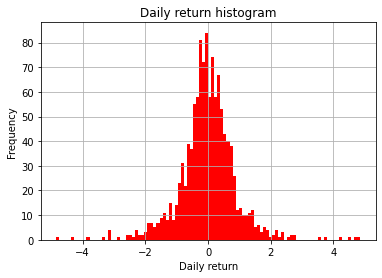

In [158]:
# Plot the histogram
data['daily_return'].hist(bins=100, color='red')
plt.ylabel('Frequency')
plt.xlabel('Daily return')
plt.title('Daily return histogram')
plt.show()

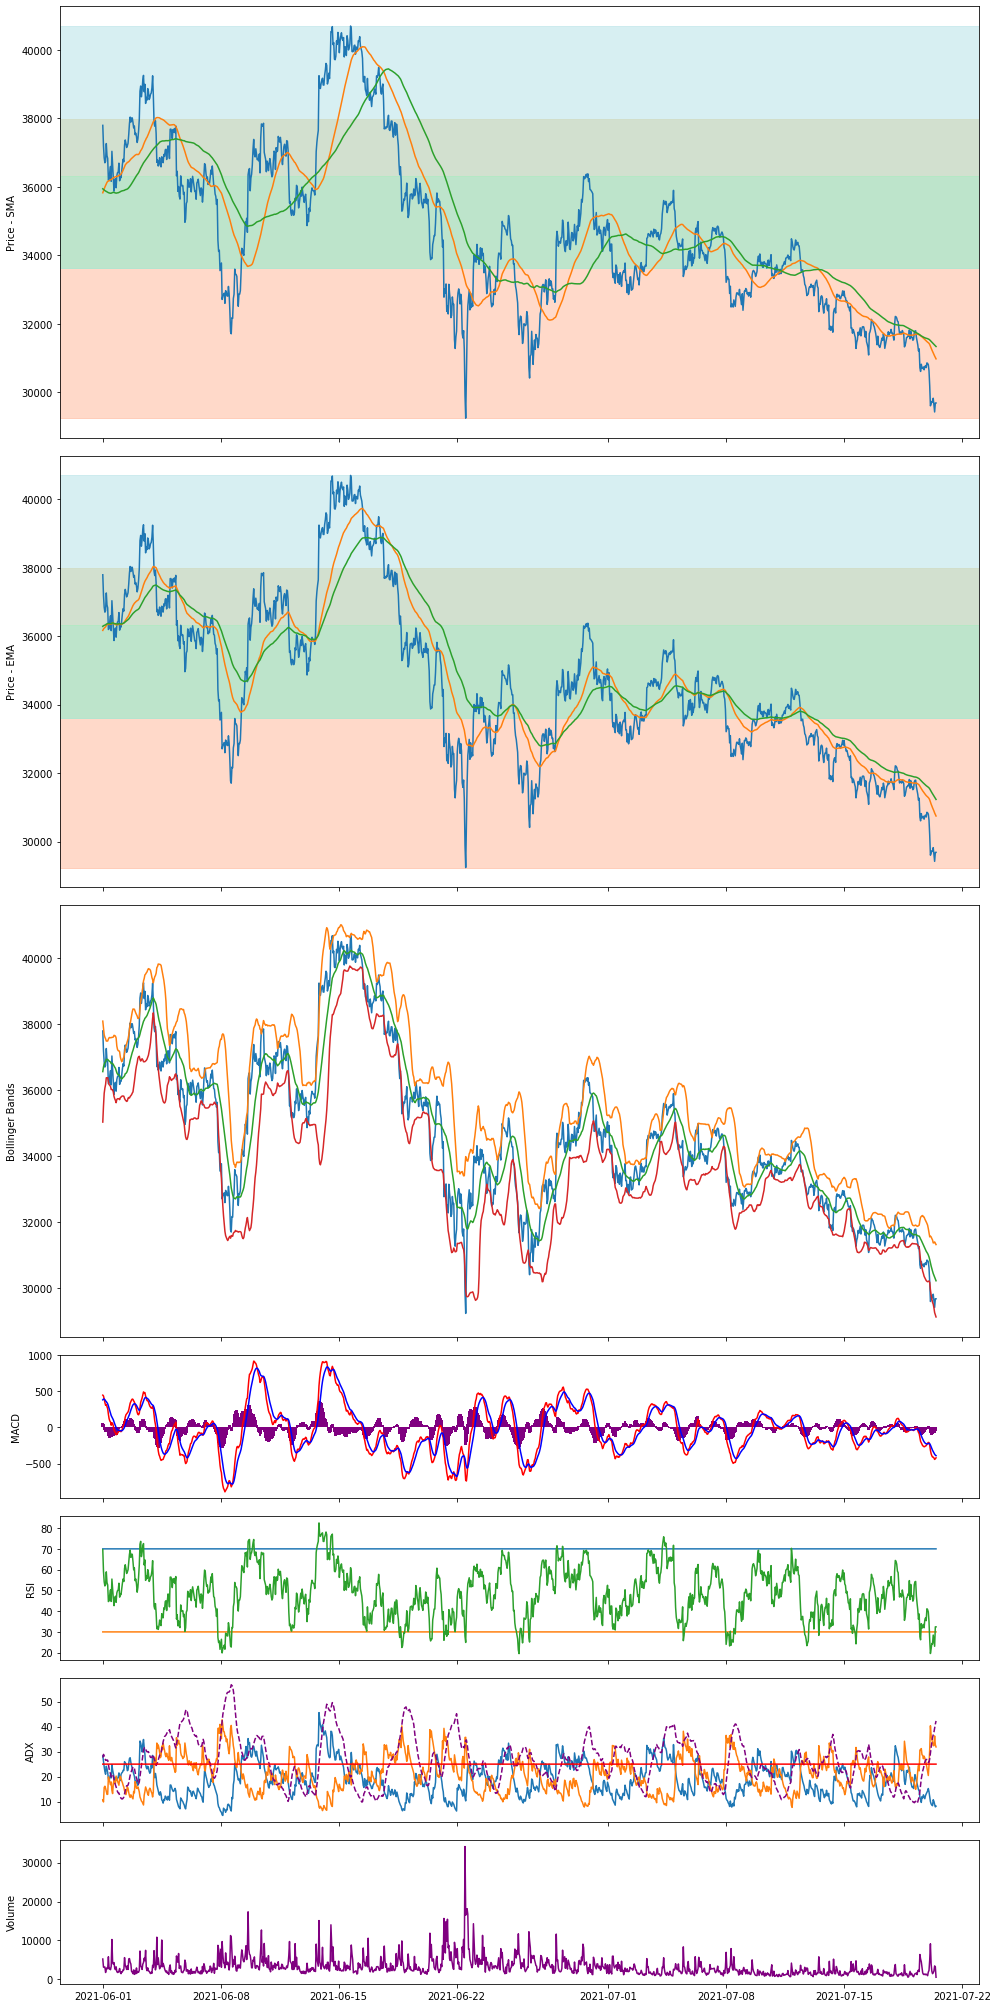

In [159]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(nrows=7, sharex=True, figsize=(14, 28), gridspec_kw = {'height_ratios':[3, 3, 3, 1, 1, 1, 1]})

# Price x SMA
ax1.plot(data.index, data[['ClosePrice', 'SMA50', 'SMA100']])
# Fibonacci retracement
ax1.axhspan(fib_levels['level1'], fib_levels['price_min'], alpha=0.4, color='lightsalmon')
ax1.axhspan(fib_levels['level2'], fib_levels['level1'], alpha=0.5, color='palegoldenrod')
ax1.axhspan(fib_levels['level3'], fib_levels['level2'], alpha=0.5, color='palegreen')
ax1.axhspan(fib_levels['price_max'], fib_levels['level3'], alpha=0.5, color='powderblue')
ax1.set_ylabel('Price - SMA')

# Price x EMA
ax2.plot(data.index, data[['ClosePrice', 'EMA50', 'EMA100']])
# Fibonacci retracement
ax2.axhspan(fib_levels['level1'], fib_levels['price_min'], alpha=0.4, color='lightsalmon')
ax2.axhspan(fib_levels['level2'], fib_levels['level1'], alpha=0.5, color='palegoldenrod')
ax2.axhspan(fib_levels['level3'], fib_levels['level2'], alpha=0.5, color='palegreen')
ax2.axhspan(fib_levels['price_max'], fib_levels['level3'], alpha=0.5, color='powderblue')
ax2.set_ylabel('Price - EMA')

# Bollinger Bands
ax3.plot(data['ClosePrice'], label='Price')
ax3.plot(data['UpperBBand'], label='Upper band')
ax3.plot(data['MidiBBand'], label='Middle band')
ax3.plot(data['LowerBBand'], label='Lower band')
ax3.set_ylabel('Bollinger Bands')

# MACD
ax4.plot(data.index, data['MACD'], label='MACD', color = 'red')
ax4.plot(data.index, data['signal'], label='Signal Line', color='blue')
ax4.bar(data.index, data['MACDH'], color="purple", width = timedelta(hours=4))
ax4.set_ylabel('MACD')

# RSI
ax5.plot(data.index, [70] * len(data.index), label='overbought')
ax5.plot(data.index, [30] * len(data.index), label='oversold')
ax5.plot(data.index, data['rsi'], label='rsi')
ax5.set_ylabel('RSI')

# ADX
ax6.plot(data.index, data[['DI+', 'DI-']])
ax6.plot(data.index, data[['ADX']], color='purple', linestyle='dashed')
ax6.plot(data.index, [25] * len(data.index), color = 'red')
ax6.set_ylabel('ADX')

# Volume
ax7.plot(data.index, data['Volume'], color='purple')
ax7.set_ylabel('Volume')

fig.tight_layout()

## Backtest Strategy

In [160]:
import bt

# Get the price data
price_data = data[['ClosePrice']].copy()

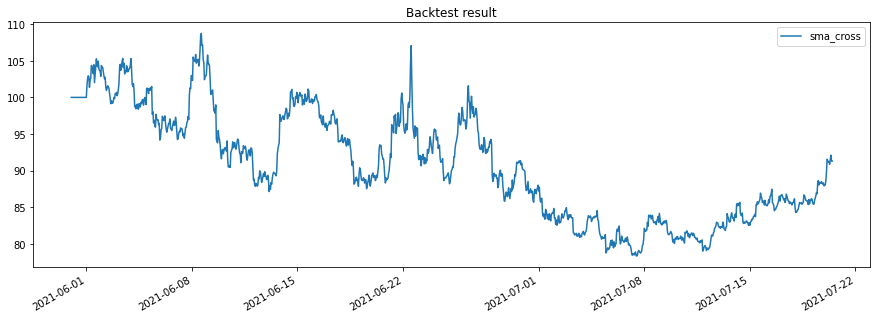

In [161]:
from backtest_utils import get_cross_signal, signal_strategy

signal = get_cross_signal(data[['SMA50']].copy(), data[['SMA200']].copy())
bt_sma_cross = signal_strategy(price_data.copy(), signal, 'sma_cross')

bt_result = bt.run(bt_sma_cross)
# Plot the backtest result
bt_result.plot(title='Backtest result')
plt.show()

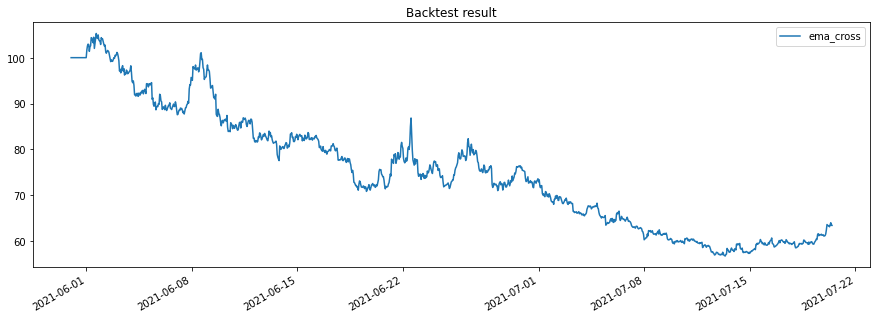

In [162]:
from backtest_utils import get_cross_signal, signal_strategy

signal = get_cross_signal(data[['EMA50']].copy(), data[['EMA200']].copy())
bt_ema_cross = signal_strategy(price_data.copy(), signal, 'ema_cross')

bt_result = bt.run(bt_ema_cross)
# Plot the backtest result
bt_result.plot(title='Backtest result')
plt.show()

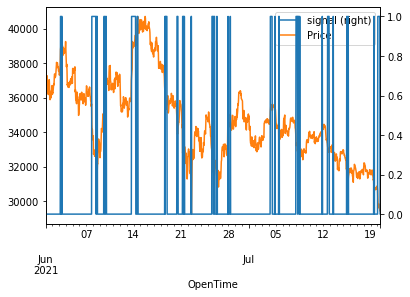

In [163]:
from backtest_utils import get_rsi_signal, signal_strategy

signal = get_rsi_signal(data[['rsi']].copy())

# Merge the data
combined_df = bt.merge(signal, price_data)
combined_df.columns = ['signal', 'Price']
combined_df.plot(secondary_y=['signal'])
plt.show()

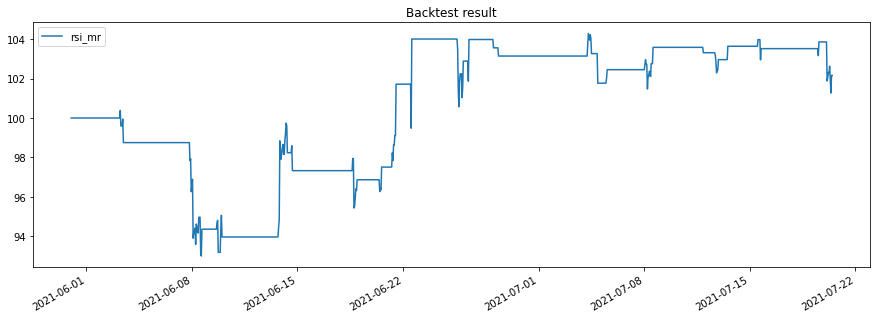

In [164]:
bt_rsi = signal_strategy(price_data.copy(), signal, 'rsi_mr')

bt_result = bt.run(bt_rsi)
# Plot the backtest result
bt_result.plot(title='Backtest result')
plt.show()

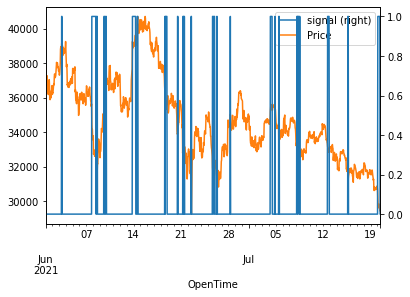

In [165]:
from backtest_utils import get_rsi_adx_signal, signal_strategy

signal = get_rsi_adx_signal(data[['rsi']].copy(), data[['ADX']])

# Merge the data
combined_df = bt.merge(signal, price_data)
combined_df.columns = ['signal', 'Price']
combined_df.plot(secondary_y=['signal'])
plt.show()

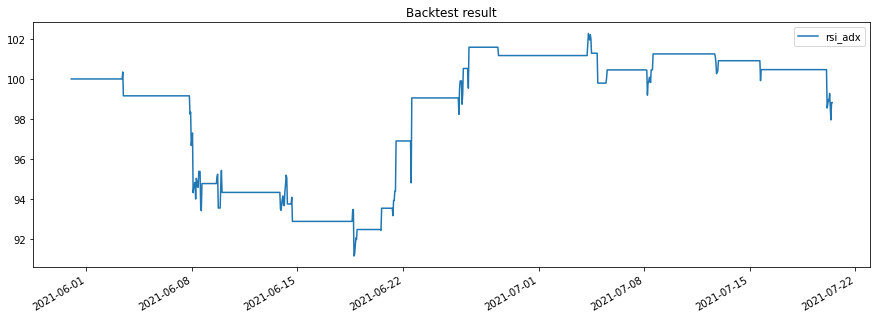

In [166]:
bt_rsi_adx = signal_strategy(price_data.copy(), signal, 'rsi_adx')

bt_result = bt.run(bt_rsi_adx)
# Plot the backtest result
bt_result.plot(title='Backtest result')
plt.show()

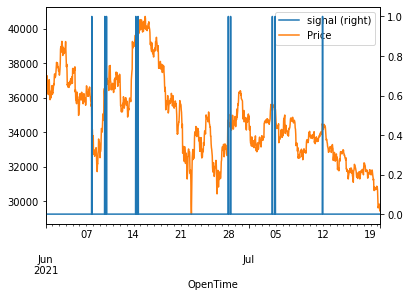

In [167]:
from backtest_utils import get_rsi_plus_signal, signal_strategy

signal = get_rsi_plus_signal(data[['rsi']].copy())

# Merge the data
combined_df = bt.merge(signal, price_data)
combined_df.columns = ['signal', 'Price']
combined_df.plot(secondary_y=['signal'])
plt.show()

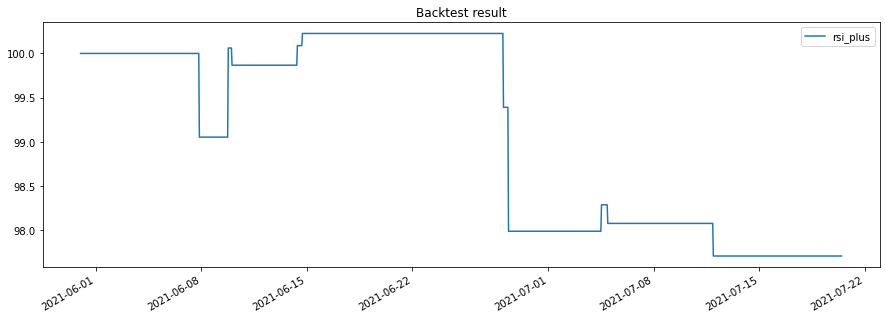

In [168]:
bt_rsi_plus = signal_strategy(price_data.copy(), signal, 'rsi_plus')

bt_result = bt.run(bt_rsi_plus)
# Plot the backtest result
bt_result.plot(title='Backtest result')
plt.show()

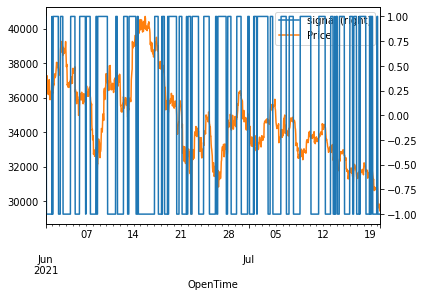

In [169]:
from backtest_utils import get_macd_signal, signal_strategy

signal = get_macd_signal(data[['signal']].copy(), data[['MACD']].copy())

# Merge the data
combined_df = bt.merge(signal, price_data)
combined_df.columns = ['signal', 'Price']
combined_df.plot(secondary_y=['signal'])
plt.show()

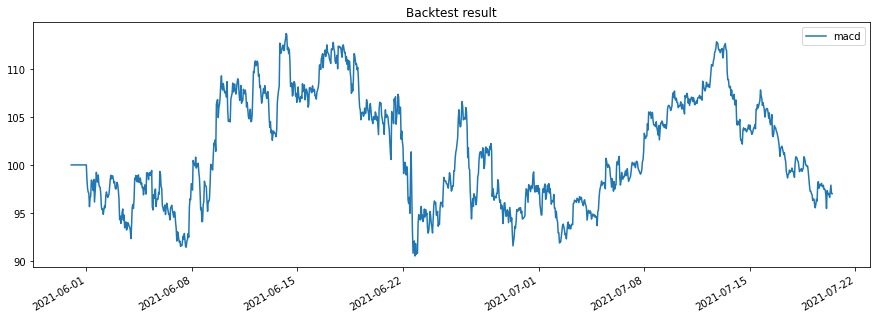

In [170]:
bt_macd = signal_strategy(price_data.copy(), signal, 'macd')

bt_result = bt.run(bt_macd)
# Plot the backtest result
bt_result.plot(title='Backtest result')
plt.show()

In [171]:
print(bt_result.display())
print(bt_result.get_transactions())

Stat                 macd
-------------------  ----------
Start                2021-05-31
End                  2021-07-20
Risk-free rate       0.00%

Total Return         -3.01%
Daily Sharpe         0.07
Daily Sortino        0.12
CAGR                 -19.98%
Max Drawdown         -19.33%
Calmar Ratio         -1.03

MTD                  -0.88%
3m                   -
6m                   -
YTD                  -3.01%
1Y                   -
3Y (ann.)            -
5Y (ann.)            -
10Y (ann.)           -
Since Incep. (ann.)  -19.98%

Daily Sharpe         0.07
Daily Sortino        0.12
Daily Mean (ann.)    4.37%
Daily Vol (ann.)     63.54%
Daily Skew           0.17
Daily Kurt           1.41
Best Day             11.90%
Worst Day            -11.38%

Monthly Sharpe       -5.82
Monthly Sortino      -5.82
Monthly Mean (ann.)  -18.15%
Monthly Vol (ann.)   3.12%
Monthly Skew         -
Monthly Kurt         -
Best Month           -0.88%
Worst Month          -2.15%

Yearly Sharpe        -
Yearly 

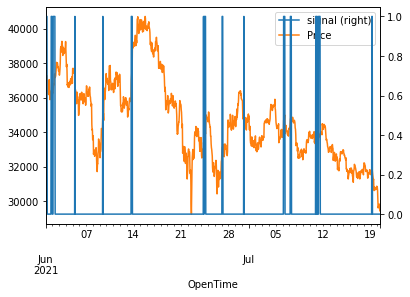

In [172]:
from backtest_utils import get_sma_macd_signal, signal_strategy

signal = get_sma_macd_signal(data[['ClosePrice']].copy(), data[['SMA50']].copy(), data[['SMA100']].copy(), data[['MACD']].copy())

# Merge the data
combined_df = bt.merge(signal, price_data)
combined_df.columns = ['signal', 'Price']
combined_df.plot(secondary_y=['signal'])
plt.show()

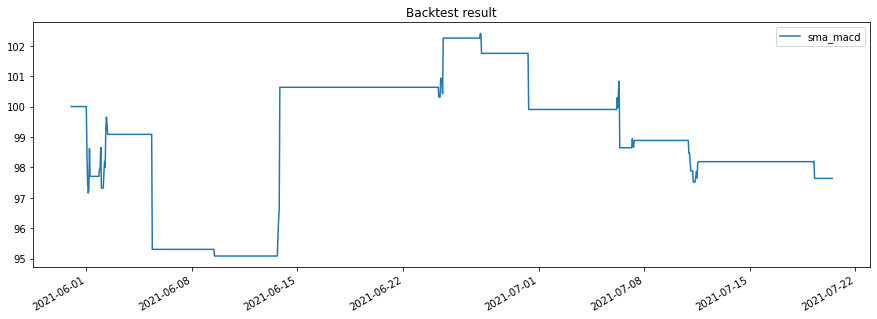

In [173]:
bt_sma_macd = signal_strategy(price_data.copy(), signal, 'sma_macd')

bt_result = bt.run(bt_sma_macd)
# Plot the backtest result
bt_result.plot(title='Backtest result')
plt.show()

In [174]:
from backtest_utils import signal_above_strategy, buy_and_hold_strategy

# Create signal strategy backtest
bt_sma5 = signal_above_strategy(price_data.copy(), data[['SMA5']].copy(), name='SMA5')
bt_sma50 = signal_above_strategy(price_data.copy(), data[['SMA50']].copy(), name='SMA50')
bt_sma100 = signal_above_strategy(price_data.copy(), data[['SMA100']].copy(), name='SMA100')

# Create benchmark strategy backtest
bt_benchmark = buy_and_hold_strategy(price_data.copy(), name='benchmark')

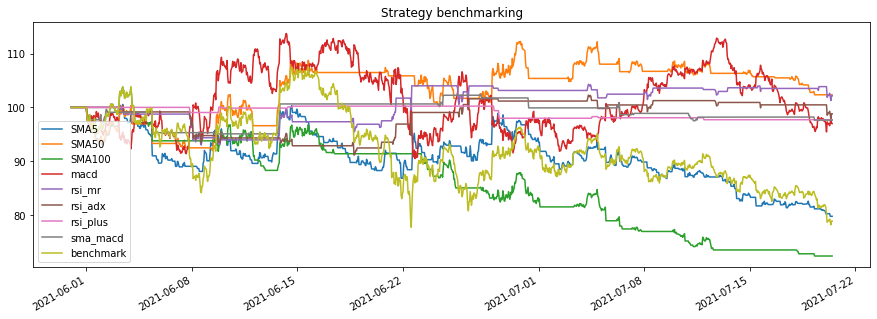

In [175]:
# Run all backtests and plot the resutls
bt_results = bt.run(bt_sma5, bt_sma50, bt_sma100, bt_macd, bt_rsi, bt_rsi_adx, bt_rsi_plus, bt_sma_macd, bt_benchmark)
#bt_results = bt.run(bt_rsi, bt_sma50, bt_benchmark)
bt_results.plot(title='Strategy benchmarking')
plt.show()

In [176]:
bt_results.display()

Stat                 SMA5        SMA50       SMA100      macd        rsi_mr      rsi_adx     rsi_plus    sma_macd    benchmark
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  -----------
Start                2021-05-31  2021-05-31  2021-05-31  2021-05-31  2021-05-31  2021-05-31  2021-05-31  2021-05-31  2021-05-31
End                  2021-07-20  2021-07-20  2021-07-20  2021-07-20  2021-07-20  2021-07-20  2021-07-20  2021-07-20  2021-07-20
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         -20.22%     2.34%       -27.59%     -3.01%      2.15%       -1.18%      -2.30%      -2.36%      -21.10%
Daily Sharpe         -2.12       0.48        -3.87       0.07        0.63        -0.32       -1.90       -0.61       -1.46
Daily Sortino        -3.81       0.99        -5.22       0.12        1.24        -0.55       -2.11       -1.04      

In [177]:
# Obtain all backtest stats
resInfo = bt_results.stats
print(resInfo.loc['total_return'])

best_strategy = ''
best_total_return = -1
for strategy, total_return in zip(resInfo.loc['total_return'].index, resInfo.loc['total_return'].values):
    if total_return > best_total_return:
        best_total_return = total_return
        best_strategy = strategy

print('Best Strategy: ' + best_strategy)

SMA5        -0.202229
SMA50        0.023375
SMA100      -0.275936
macd        -0.030058
rsi_mr       0.021549
rsi_adx     -0.011823
rsi_plus    -0.022959
sma_macd    -0.023637
benchmark   -0.210991
Name: total_return, dtype: object
Best Strategy: SMA50


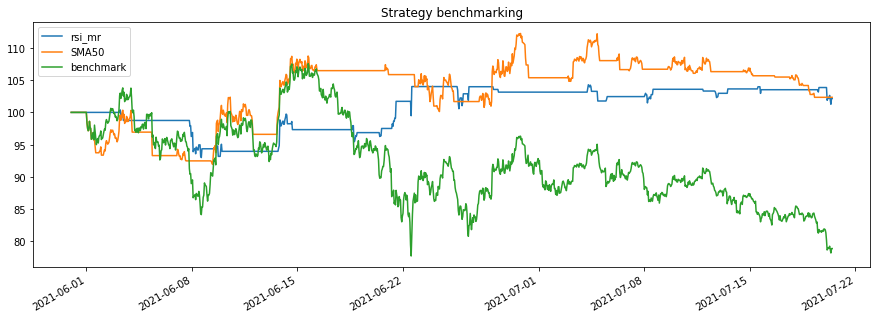

In [178]:
bt_results = bt.run(bt_rsi, bt_sma50, bt_benchmark)
bt_results.plot(title='Strategy benchmarking')
plt.show()

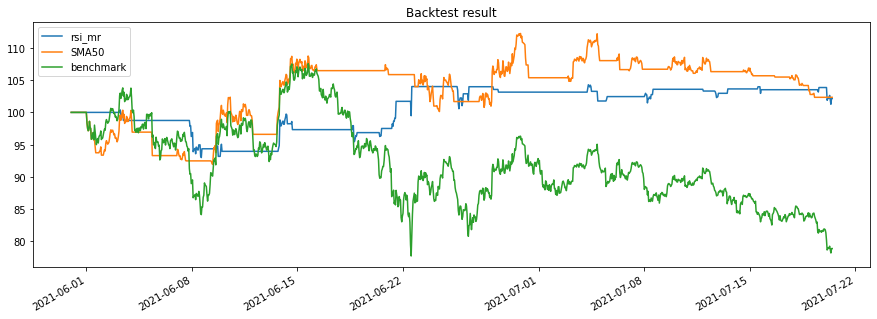

       rsi_mr   SMA50 benchmark
mtd    -0.95%  -2.88%   -15.02%
3m       nan%    nan%      nan%
6m       nan%    nan%      nan%
ytd     2.15%   2.34%   -21.10%
1y       nan%    nan%      nan%
3y       nan%    nan%      nan%
5y       nan%    nan%      nan%
10y      nan%    nan%      nan%
incep  16.85%  18.39%   -82.29%


In [179]:
# Plot the backtest result
bt_results.plot(title='Backtest result')
plt.show()

# Get the lookback returns
lookback_returns = bt_results.display_lookback_returns()
print(lookback_returns)

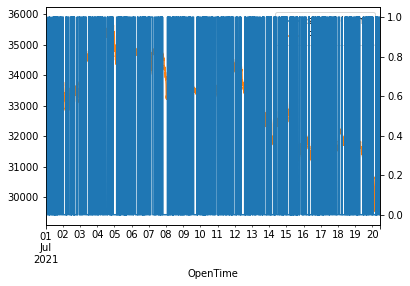

In [180]:
from backtest_utils import get_5_minute_signal, signal_strategy
import bt

summaries = {'OpenPrice': 'first', 'HighPrice': 'max', 'LowPrice': 'min', 'ClosePrice': 'last', 'Volume': 'sum'}
df_5m = df.resample('5min').agg(summaries)
df_5m.dropna(inplace=True)

df_5m['EMA20'] = ema(df_5m['ClosePrice'], 20)
df_5m['MACD'], df_5m['signal'], df_5m['MACDH'] = macd(df_5m.ClosePrice)

df_5m = df_5m['2021-7-1':]

signal = get_5_minute_signal(df_5m[['ClosePrice']].copy(), df_5m[['MACDH']].copy(), df_5m[['EMA20']].copy())

# Merge the data
combined_df = bt.merge(signal, df_5m[['ClosePrice']])
combined_df.columns = ['signal', 'Price']
combined_df.plot(secondary_y=['signal'])
plt.show()

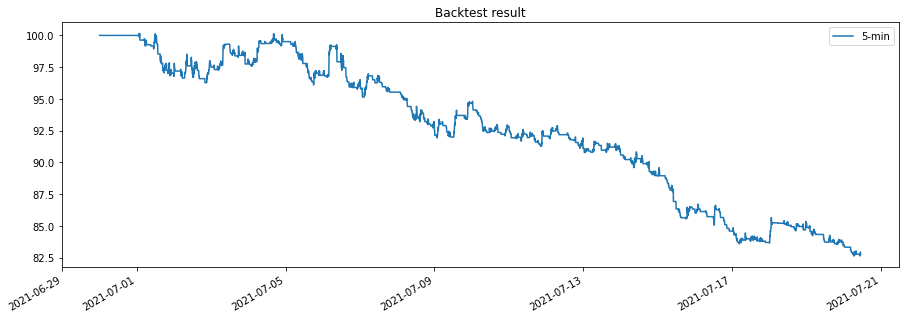

In [181]:
bt_backtest = signal_strategy(df_5m[['ClosePrice']].copy(), signal, '5-min')

bt_result = bt.run(bt_backtest)
# Plot the backtest result
bt_result.plot(title='Backtest result')
plt.show()

## Tests

In [ ]:
from binance_utils import init
from binance.client import Client

client = init()
candles = client.get_klines(symbol='BTCUSDT', interval=Client.KLINE_INTERVAL_1HOUR)